In [1]:

import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.nn import Parameter
from torch.nn import functional as F

from scipy.special import binom

import clingo
import numpy as np

import math
from IPython.display import clear_output

from numpy.random import random_integers as rndint
import pandas as pd
import copy
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from SimpleMazeNewMarsh1 import *


def get_agent_pov(length, state, env):
    loc = torch.where(state[:, 1, :, :] == 1)
    x_locs = loc[1]
    y_locs = loc[2]
    #     length = 5

    bxl = np.maximum(x_locs - int(length / 2), 0)
    bxu = np.minimum(x_locs + int(length / 2) + 1, env.maze.shape[0])
    byl = np.maximum(y_locs - int(length / 2), 0)
    byu = np.minimum(y_locs + int(length / 2) + 1, env.maze.shape[0])

    current_M = env.get_super_manager_1([x_locs.item(), y_locs.item()])[1]
    for x in range(bxl.item(), bxu.item(), 1):
        for y in range(byl.item(), byu.item(), 1):
            m = env.get_super_manager_1([x, y])[1]

            if current_M == m:
                #             print(x,y)
                # if [x, y] != [x_locs, y_locs]:
                state[:, 1, x, y] = -1

    new_state = state[:, :, bxl:bxu,
                byl:byu]
    if y_locs - (int(length / 2)) < 0:
        s1 = np.minimum(np.abs(y_locs - (int(length / 2))), int(length / 2))
        s2 = 0
    elif (int(length / 2) + y_locs) > env.maze.shape[0] - 1:
        s1 = 0
        cc = np.abs(int(length / 2) + y_locs) + 1 - env.maze.shape[0]

        s2 = np.minimum(int(length / 2) + 1, cc)
    else:
        s1 = 0
        s2 = 0

    if x_locs - (int(length / 2)) < 0:
        s3 = np.minimum(np.abs(x_locs - (int(length / 2))), int(length / 2))
        s4 = 0
    elif (int(length / 2) + x_locs) > env.maze.shape[0] - 1:
        s3 = 0
        cc = np.abs(int(length / 2) + x_locs) + 1 - env.maze.shape[0]
        s4 = np.minimum(cc, int(length / 2) + 1)
    else:
        s3 = 0
        s4 = 0

    #     F.pad(new_state[:, 1, :, :], pad=(s1,s2,s3,s4),
    #                 value=0)
    a_1 = F.pad(new_state[:, 0, :, :], pad=(s1, s2, s3, s4),
                value=1)
    a_2 = F.pad(new_state[:, 1, :, :], pad=(s1, s2, s3, s4),
                value=1)
    blayer = torch.stack((a_1, a_2)).permute(1, 0, 2, 3)
    # print(blayer.size())
    return blayer


def clear():
    os.system('cls')


from collections import defaultdict
from tqdm import tqdm as tqdm


class QNetwork(nn.Module):

    def __init__(self, env, n_input, num_hidden, device, length):
        nn.Module.__init__(self)
        #         num_hidden=50
        self.num_hidden = num_hidden
        self.l1 = nn.Linear(n_input - env.n_layers-5, num_hidden)
        self.device = device
        self.l2 = nn.Linear(num_hidden, int(num_hidden))
        self.task_layer = nn.Linear(5, int(num_hidden))
        self.man_layer = nn.Linear(env.n_layers + 1, 1)
        #         self.l4 = nn.Linear(num_hidden, num_hidden)
        self.l4 = nn.Linear(int(num_hidden), int(num_hidden))
        self.l3 = nn.Linear(int(num_hidden), 5)
        self.conv_1 = nn.Conv2d(2, 2, kernel_size=3, stride=1)
        #         if length<4:
        #             self.stride_x=4
        #             self.K=4

        #         else:
        #             self.stride_x=2
        self.K = env.maze.shape[0] - length + 1
        self.subsample = nn.AvgPool2d(kernel_size=env.manager_view, stride=env.manager_view, ceil_mode=True)
        self.loc = copy.copy(env.agent_init_state)
        self.length = length
        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]
        self.n_layers = env.n_layers
        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [np.random.randint(4) for x in range(int(env.n_layers))]
        self.hierarchy_actions[0] = 4
        self.expected_level = 0

        self.lims = self.get_super_manager_1(env, [env.maze.shape[1], env.maze.shape[1]])
        self.search_lims = [env.maze.shape[0] * 1.5 * x[0] for x in self.lims][::-1]
        self.search_lims[-1] = np.maximum(6, self.search_lims[-1])
        self.search_lims[0] = 100000
        # self.blur_layer = BesselConv2d(1, zero_scale=0.25, base=2, n_scales=2)

    #         self.conv_layer =nn.Conv2d(1,1,env.maze.shape[0]-length+1,1)
    #         self.conv_layer.weight=torch.nn.Parameter(torch.ones_like(self.conv_layer.weight),requires_grad=False)
    #         self.conv_layer.bias=torch.nn.Parameter(torch.zeros_like(self.conv_layer.bias),requires_grad=False)
    # man_conv_layer=nn.Conv2d(2,2,4,1)
    # bb=get_agent_pov(5,state,env)

    def reset(self, env):
        self.loc = copy.copy(env.agent_init_state)

        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]

        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [np.random.randint(4) for x in range(int(env.n_layers))]
        self.hierarchy_actions[0] = 4
        #         [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

    def forward(self, x, y, env):
        # try:
        #     x=x[:,:]
        # except:
        #     pass
        l = self.length
        el = env.maze.shape[0]

        if y != self.n_layers:
            #             # x1=self.conv_layer(x[:128].reshape(1,2,8,8))
            # x1=x1.flatten()

            pd = int(self.length / 2)
            mz = x.flatten()[:el ** 2].reshape(1, 1, el, el)

            aloc = x.flatten()[el ** 2:2 * el ** 2].reshape(1, 1, el, el)

            for r in range(int(self.n_layers - y)):
                mz = self.subsample(mz)
                aloc = self.subsample(aloc)
            # print(aloc)

            # if torch.sum(aloc).item() > 1:
            #     print('hang on a second')

            try:
                mz = F.pad(mz[:
                           , :, :, :], pad=(pd, pd, pd, pd),
                           value=1)

                aloc = F.pad(aloc[:
                             , :, :, :], pad=(pd, pd, pd, pd),
                             value=.00000001)

                pov = int(l / 2)
                _, _, xc, yc = torch.where(aloc == torch.max(aloc))
                # print(aloc)
                # print(xc,yc)
                xc = xc[0]  #
                yc = yc[0]
                mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
                aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

                aloc = torch.ceil(aloc - torch.min(aloc))
            except:
                print('nnn')
            aloc[:, :, 3, 3] = -1
            mz = torch.ceil(mz - torch.min(mz))

            mat_1 = mz.reshape(1, int(l ** 2))

            mat_2 = aloc.reshape(1, int(l ** 2))
            #             print(mat_1)
            #             print(mat_2)
            #             x11=torch.cat((self.conv_layer(x.flatten()[:64].reshape(1,1,8,8)),self.conv_layer(x.flatten()[64:128].reshape(1,1,8,8)).reshape(1,int(l**2))),dim=1)
            # x11 = torch.cat((mat_1, mat_2), dim=1)
            # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
            x11 = torch.stack((mat_1, mat_2)).view(1, 2, 7, 7)
            #             x=torch.cat((x11,x.flatten()[128:].reshape(1,8)),dim=1)
            # torch.stack((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(50,1).T,x[128:].flatten().reshape(8,1).T))
            #             x11=self.conv_1(x11)
            ll = len(x11.to(self.device).flatten())
            out = self.l1(x11.to(self.device).flatten().view(1, ll))
        else:
            state = x.flatten()[:2 * el ** 2].reshape(1, 2, el, el)
            x_1 = get_agent_pov(self.length, state, env)
            #             print(x_1.size())
            # x_1 = x_1[:, 0, :, :]
            #             x11 = self.conv_1(x_1)
            ll = len(x_1.to(self.device).flatten())
            out = self.l1(x_1.to(self.device).flatten().view(1, ll))
            # x=torch.cat((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(1,50),x[128:].flatten().reshape(1,8)),dim=1)
        # torch.cat((x_1,x[128:]))
        #             print(x_1.size())
        #             print(x)
        #             x_1=torch.cat((x_1.reshape(1,int(2*(l**2))),x.flatten()[128:].reshape(1,8)),dim=1)
        #         print(x)
        if x.size()[0] == 2 * el ** 2 + env.n_layers + 1 + 5:
            x = x.unsqueeze(0)
        man = self.man_layer(x[:, 2 * el ** 2:2 * el ** 2 + env.n_layers + 1].to(self.device))
        task = self.task_layer(x[:, 2 * el ** 2 + env.n_layers + 1:].to(self.device))
        #         print(out.size(),man.size(),task.size())

        #         out = self.l2(F.relu(out))
        out = F.relu(out) * F.relu(task)
        #         out = self.l4(F.relu(out))
        out = self.l3(F.relu(out) * man)
        return out

    def init_super_manager(self, env):
        n_layers = env.n_layers + 1
        self.super_managers = []
        number_of_levels = n_layers
        self.super_managers.append([np.floor(x / env.manager_view) for x in self.loc])
        if number_of_levels - 2 > 1:
            for i in range(int(number_of_levels - 2)):
                self.super_managers.append([np.floor(x / env.manager_view) for x in self.super_managers[-1]])
        else:
            self.super_managers.append([0, 0])
        self.super_managers = self.super_managers[::-1]

    def get_super_manager_1(self, env, loc):
        #         find which super manager per finest location state
        super_managers = []
        number_of_levels = int(env.n_layers)
        #         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
        # print(loc)
        super_managers.append([np.floor(x / env.manager_view) for x in loc])
        if number_of_levels - 1 > 1:
            for i in range(number_of_levels - 1):
                super_managers.append([np.floor(x / env.manager_view) for x in super_managers[-1]])
        #                 print(i)
        else:
            super_managers.append([0, 0])
        return super_managers[::-1]

    def get_subs(self, mans, env, level):
        if level == 0:
            subs = []
            for x in range(env.maze.shape[0]):
                for y in range(env.maze.shape[0]):
                    subs.append([x, y])
            #                     index_list.append(x*env.maze.shape[0]+y)
            return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
        else:
            step_view = env.manager_view ** (env.n_layers - level)
            xs = []
            ys = []
            #             step_view = 2

            for i in range(0, step_view, 1):
                xs.append(mans[0] * step_view + i)
            for i in range(0, step_view, 1):
                ys.append(mans[1] * step_view + i)
            subs = []
            index_list = []
            for x in xs:
                for y in ys:
                    subs.append([x, y])
                    index_list.append(x * env.maze.shape[0] + y)

            return np.array([int(x) for x in index_list]), subs


def get_epsilon(it):
    # YOUR CODE HERE
    #     raise NotImplementedError

    epsilon = np.maximum(.8 + - .8 * ((it) / 15000), .1)

    #     return epsilon
    return epsilon


class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """

    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def sample_action(self, obs, allowed_actions, i, num_eps, level):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            obs: current state

        Returns:
            An action (int).

        """
        if level != env.n_layers:
            eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.15 / num_eps))
        else:
            eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.8 / num_eps))
#         eps = 0.15
        # YOUR CODE HERE
        #         raise NotImplementedError
        with torch.no_grad():

            # Pytorch can be pretty annoying with its data types!
            state = torch.tensor(obs, dtype=torch.float)

            # get the q values for each action given by the model
            q_sa = self.Q.forward(state, level, env)
            #             print(q_sa)
            # random number to decice each action to take
            choice = torch.rand(1).item()

            if choice < eps:
                # Uniform sampling
                return np.random.choice(allowed_actions), eps

            else:
                # Select the greedy action
                a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                return a, eps

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon


def compute_q_vals(Q, states, ys, env, actions):
    ss = states.clone()
    return Q.forward(ss, ys, env).gather(dim=1, index=actions).squeeze()


def compute_targets(Q, rewards, states, next_states, dones, discount_factor, allowed_actions_current,
                    allowed_actions_next, ys, env, reason, i, num_episodes,epg):
    #     try:

    #     print(ys)
    #     print(ys!=env.n_layers)
    el=env.maze.shape[0]
    reason = reason[0]
    if ys.item()  in [0,1]:
        if dones:
            targets = rewards
        else:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()
    else:
        if dones:
            targets = rewards
        #                 TS
        elif reason in [1, 3]:
            targets = rewards

        #             TF
        #         elif reason==3:
        #     #                 man_state=env.get_super_manager_1(ns)[level-1]
        #     #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
        #     #                 task=tasks[level-2]
        #     #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
        #             targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
        #                                                            [x[1][allowed_actions_current[x[0]]] for x in
        #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
        #             len(states), 1) * (1 - dones).float()
        # #         + discount_factor * torch.stack([torch.max(y) for y in
        # #                                                            [x[1][allowed_actions_current[x[0]]] for x in
        # #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
        # #             len(states), 1) * (1 - dones).float()

        # sl
        elif reason == 2:

            ss2 = torch.zeros_like(states)
            level2 = ys.item() - 1
            # print(states.shape)
            ss2[:,:2*el**2] = states[:,:2*el**2]
            ss2[:,int(2*el**2 + level2)] = 1

            t = Q.hierarchy_actions[int(level2 - 1)]
            ss2[:,2*el**2 + env.n_layers + 1 + t] = 1
            allowed_actions_n = env.possible_actions(int(level2), ss2)
            a, eps = epg.sample_action(ss2, allowed_actions_n, i + 1, num_episodes, int(level2))
            t_new=a
            ss1 = torch.zeros_like(states)
            ss1[:, :2*el**2 + env.n_layers ] = states[:, :2*el**2 + env.n_layers ]
            ss1[:, 2*el**2+ env.n_layers + 1 + t_new] = 1


            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_current[x[0]]] for x in
                                                                enumerate(Q.forward(ss1, ys, env))]]).reshape(
                len(states), 1) * (1 - dones).float()
        # no managerial change
        else:
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()

    #     except:
    #         print('aaa')
    return targets


class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            self.memory = self.memory[-self.capacity:]

    def sample(self, batch_size):
        idxs = np.random.randint(len(self.memory), size=batch_size)

        return np.array(self.memory)[idxs]

    def __len__(self):
        return len(self.memory)


def train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler, i, num_episodes,epg):
    # DO NOT MODIFY THIS FUNCTION

    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    device = torch.device(dev)
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)

    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done, allowed_actions_next, ys, reason, allowed_actions_current = zip(
        *transitions)

    # convert to PyTorch and define types
    # state = torch.stack(state).squeeze(1).to(device)
    state = torch.tensor(state, dtype=torch.float).to(device)
    ys = torch.tensor(ys, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)[:, None]  # Need 64 bit to use them as index
    # next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)[:, None]
    done = torch.tensor(done, dtype=torch.uint8).to(device)[:, None]  # Boolean
    # allowed_actions_next=torch.tensor(allowed_actions_next, dtype=torch.int64).to(device)

    # compute the q value
    q_val = compute_q_vals(Q_policy, state, ys, env, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q_target, reward, state, next_state, done, discount_factor, allowed_actions_current,
                                 allowed_actions_next, ys, env, reason, i, num_episodes,epg)
        # print('target', target)
    loss = F.mse_loss(q_val.reshape(batch_size, 1), target)
    # clear()
    # print(env.loc,flush=True)
    # print(loss.item(),flush=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()


# loc_maze=np.zeros((env.maze.shape[0],env.maze.shape[0]))
# loc_maze[Q_policy.loc[0],Q_policy.loc[1]]=1
#
# a=torch.tensor(env.maze)
# b=torch.tensor(loc_maze)
# c=torch.stack((a,b)).float()
# d=a1(c.unsqueeze(0))
# state=c.unsqueeze(0)
#
# # stride
# man_conv_layer=nn.Conv2d(2,2,4,1)
# bb=get_agent_pov(5,state,env)
# man_conv_layer(state).squeeze(0).flatten().detach().numpy()


def run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                 min_episodes):
    optimizer = optim.AdamW(Q_policy.parameters(), learn_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                            amsgrad=False)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes, eta_min=0)
    dev = 'cpu'
    global_steps = 0
    losses = []
    rewards = []
    dd = []
    cl = []
    # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    Visit_table = {}
    for l in range(env.n_layers + 1):
        Visit_table[l] = {}
        for s in range(env.maze.shape[0] ** 2):
            Visit_table[l][s] = {}
            for t in range(5):
                Visit_table[l][s][t] = {}
                for a in range(5):
                    Visit_table[l][s][t][a] = 0
    pos_man = 64

    #     int((env.maze.shape[0]/env.manager_view)**2)
    for i in tqdm(range(num_episodes)):
        episode = i
        env.reset()
        #         Q_policy.loc=copy.copy(env.agent_init_state)
        #         Q_target.loc=copy.copy(env.agent_init_state)
        Q_policy.reset(env)
        Q_target.reset(env)

        #         print('Goal', env.goal_init_state)
        #         print('Agent', Q_policy.loc)
        # agent_row = env.maze.flatten()
        agent_row = copy.copy(env.maze)
        #         agent_row[int(state[0])][int(state[1])] = 1
        #         n_agent_row_1 = np.reshape(agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
        #         state = torch.tensor(n_agent_row_1, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
        step_counter = 0
        if i > min_episodes:
            if pd.Series(episode_durations).rolling(300).mean().tail(1).values[0] < 5.:
                print('average less than 4.5')
                d = True
            else:
                d = False
                if i > 1000:
                    a = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().shift(100)
                    a2 = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().expanding().min()
                    if a.abs().rolling(100).mean().tail(1).values[0] < .01:
                        print(a.abs().rolling(100).mean().tail(1).values[0])
                        print('Converged')
                        d = True
                    elif a2.tail(1).values[0] > np.maximum(pd.Series(episode_durations).rolling(300).mean().min(), 100):
                        print('Diverged1')
                        d = True


                    elif a.rolling(3).mean().tail(1).values[0] > 1000:
                        print('Diverged2')
                        d = True

                    else:
                        d = False
        #             if pd.Series(rewards).rolling(100).mean().tail(1).values[0]>-8:
        #                     d=True
        # if pd.Series(episode_durations).rolling(200).mean().tail(1).values[0] - \
        #         pd.Series(episode_durations).rolling(200).mean().shift(-20).dropna().tail(1).values[0] > 30:
        #     d = True

        else:
            d = False
        old_step_counter = 0
        r2 = 0
        #         clear_output(wait=True)

        while d != True:
            moved_from_goal = False
            # env.current_level=2
            #             print('episode',episode)
#             print('Current position', Q_policy.loc)
            level2 = copy.copy(Q_policy.current_level)
            state_1 = copy.copy(Q_policy.loc)
            current_loc = copy.copy(Q_policy.loc)

            #
            # print('loc',current_loc)
            # print('Task/Actions')
            # print(Q_policy.hierarchy_actions)

            current_level = copy.copy(Q_policy.current_level)
            #             print('level',current_level)
            allowed_actions = env.possible_actions(current_level, current_loc)

            state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
            #             if current_level==env.n_layers:
            state[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            if current_level == 0:
                loc_idx2 = 0

            #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
            #                                                  current_level)
            elif current_level != env.n_layers:
                #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
                #                                                  current_level)
                # loc_idx2 = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env, current_level)
                # print(current_level,rf)
                # print(current_loc)
                # print(loc_idx2,locs)
            #                 loc_idx3 = [x for x in range(pos_man)rf if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     state[jl + env.maze.shape[0] ** 2] = .1
            state[loc_idx2 + env.maze.shape[0] ** 2] = 1
            man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
            state[man_idx] = 1
            cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1

            if current_level != 0:
                task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                ttt = Q_policy.hierarchy_actions[current_level - 1]
            else:
                task_idx = cc + 4
                ttt = 4
            state[task_idx] = 1

            if level2 == env.n_layers:
                old_step_counter = step_counter
                step_counter = step_counter + 1
                global_steps = global_steps + 1

            epsilon = get_epsilon(global_steps)
            epg = EpsilonGreedyPolicy(Q_policy, epsilon)
            #             if current_level == 0:
            #                 a = 4
            #             else:
            #                 a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)

            if current_level == 0:
                a = 4
            else:
                a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
                #                 print(env, level2,state_1,Q_policy.hierarchy_actions[level2 - 1])
                # a, eps = FlatQ.choose_action(env, level2, state_1, Q_policy.hierarchy_actions[level2 - 1], episode,
                #                              num_episodes)
            #             print(action)
            #             print('Action', allowed_actions, a)
            #             env.check_dicts[0][current_level][a] += 1
            if current_level == env.n_layers:
                Visit_table[current_level][loc_idx2][ttt][a] += 1
            elif current_level == env.n_layers - 1:
                loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0] / env.manager_view + int(
                    current_loc[1] / env.manager_view)
                Visit_table[current_level][loc_level][ttt][a] += 1
            ns, d = env.step(a, current_level, Q_policy)
            #             print(current_loc,a,ns)
            nl = copy.copy(Q_policy.current_level)
            #             print('NewState', ns)
            #             print('New level', Q_policy.current_level)
            #             print('----------------------------------------')
            #             print('Goal:', i, env.goal_init_state)
            #             print(current_loc, current_level)
            #             print(allowed_actions, a)
            #             print(ns, Q_policy.current_level)
            #             print('----------------------------------------')
            Q_policy.loc = copy.copy(ns)
            #             print(step_counter)
            statef = env.get_super_manager_1(ns)[1]

            if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                # assert Q_policy.hierarchy_actions[level]!=4
                # if
                if Q_policy.hierarchy_actions[1] == 4:
                    #                     print('xxxxxx')
                    moved_from_goal = True

            if step_counter > 0:
                if Q_policy.current_level != 0:
                    #                     print('checking if level should change')
                    env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy, moved_from_goal)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
            else:
                Q_policy.expected_level = copy.copy(Q_policy.current_level)
            #             print('Expected level', Q_policy.expected_level)

            old_reset = copy.copy(env.reset_reward)
            #             if current_level==2:
            #                 print(env.reset_reward,env.reset_reward_2)

            r = env.reward(Q_policy, d, current_level)
            # print(r)
            #             if current_level==2:
            #                 print(r)
            #             if moved_from_goal:
            #                 if r[-1] == -1:
            #                     break
            #                     print('hold up')

            if d == True:
                env.reset_reward = [5 for x in env.reset_reward]

            n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2 + env.n_layers + 1 + 5)
            #             if current_level == env.n_layers:
            n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
            loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
            if Q_policy.expected_level == 0:
                loc_idx2 = 0
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            elif Q_policy.expected_level != env.n_layers:
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in ns], env, current_level)
                # loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0] / env.manager_view + int(
                #     ns[1] / env.manager_view)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     n_agent_row[jl + env.maze.shape[0] ** 2] = .10
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)

            #             print(loc_idx2)
            #             print(int(env.maze.shape[0] ** 2) + loc_idx2)
            n_agent_row[env.maze.shape[0] ** 2 + loc_idx2] = 1
            man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
            n_agent_row[man_idx] = 1
            if nl != 0:
                task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
            else:
                task_idx = cc + 4
            n_agent_row[task_idx] = 1
            #             print('-ll-')
            #             print(state)
            #             print(n_agent_row)
            for x in enumerate(old_reset):
                level = x[0]
                x = x[1]
                reason = x
                allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)
                allowed_actions_current = env.possible_actions(level, state_1)

                #                 env.get_possible_actions(ns, level)

                if level2 == env.n_layers:
                    r2 += r[-1]
                    if level == env.n_layers:

                        #                         FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
                        #                                               Q_policy.hierarchy_actions[level - 1], d,
                        #                                               episode, num_episodes, discount_factor)
                        #
                        FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
                                              Q_policy.hierarchy_actions[level - 1], d,
                                              episode, num_episodes, discount_factor, allowed_actions_next)
                        assert allowed_actions_next == [0, 1, 2, 3]
                        memory.push((state, a, r[level], n_agent_row, d, allowed_actions_next, level, reason,
                                     allowed_actions_current))
                        loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler,
                                     i, num_episodes,epg)
                        losses.append(loss)
                    else:

                        if x not in [0]:
                            if level not in [env.n_layers, 0]:
                                statef = env.get_super_manager_1(current_loc)[level]
                                ns_1 = env.get_super_manager_1(Q_policy.loc)[level]
                                #                                 if statef != env.get_super_manager_1(env.goal_init_state)[level]:
                                #                                     # assert Q_policy.hierarchy_actions[level]!=4
                                #                                     # if
                                #                                     if Q_policy.hierarchy_actions[level] == 4:
                                #                                         print('x')
                                #                                         break
                                #                                 FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
                                #                                                       Q_policy.hierarchy_actions[level],
                                #                                                       Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
                                #                                                       discount_factor)
                                FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
                                                      Q_policy.hierarchy_actions[level],
                                                      Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
                                                      discount_factor, allowed_actions_next)

                                # print(ns,level)
                                if env.get_super_manager_1(ns)[level] == env.get_super_manager_1(env.goal_init_state)[
                                    level]:
                                    # try:
                                    if env.search_clause == True:
                                        allowed_actions_next == [4]

                                else:
                                    if env.search_clause == True:
                                        assert all(a in [0, 1, 2, 3, ] for a in allowed_actions_next)
                                    else:
                                        assert all(a in [0, 1, 2, 3, 4] for a in allowed_actions_next)

                                state_ll = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
                                #                             loc_idx = int(env.maze.shape[0] * state_l[0] + state_l[1])
                                state_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level == 0:
                                    loc_idx2 = 0
                                #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                #                                                                      level)
                                elif level != env.n_layers:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(state_1[0] / env.manager_view) * 4 + int(
                                    #     state_1[1] / env.manager_view)

                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env,
                                                                       level)
                                    # loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                    #                                    env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         state_ll[jl + env.maze.shape[0] ** 2] = .1
                                state_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1
                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                state_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level - 1]
                                else:
                                    task_idx = cc + 4
                                state_ll[task_idx] = 1

                                n_agent_row_ll = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers + 1 + 5)
                                #                             loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                                n_agent_row_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level != 0:
                                    level3 = level - 1
                                else:
                                    level3 = 0
                                if level == 0:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)

                                    loc_idx2 = 0
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(ns[0] / env.manager_view) * 4 + int(ns[1] / env.manager_view)
                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in Q_policy.loc], env,
                                                                       level)

                                    # loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                    #                                    env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         n_agent_row_ll[jl + env.maze.shape[0] ** 2] = .1
                                n_agent_row_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                n_agent_row_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level3]
                                else:
                                    task_idx = cc + 4
                                n_agent_row_ll[task_idx] = 1
                                #                                 print('ll')
                                #                                 print(state_ll)
                                #                                 print(n_agent_row_ll)

                                #                         update q values
                                memory.push((state_ll, a, r[level], n_agent_row_ll, d, allowed_actions_next, level,
                                             reason, allowed_actions_current))
                                loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev,
                                             scheduler, i, num_episodes,epg)
                                losses.append(loss)

            #             n_agent_row = np.reshape(n_agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
            #             n_agent_row = torch.tensor(n_agent_row, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
            state = n_agent_row
            Q_policy.current_level = copy.copy(Q_policy.expected_level)
            Q_target.current_level = copy.copy(Q_policy.expected_level)
            Q_target.loc = copy.copy(Q_policy.loc)
            Q_target.expected_level = copy.copy(Q_policy.expected_level)
            Q_target.current_tasks_loc = copy.copy(Q_policy.current_tasks_loc)
            Q_target.tasks = copy.copy(Q_policy.tasks)
            Q_target.tasks_bools = copy.copy(Q_policy.tasks_bools)
            Q_target.hierarchy_actions = copy.copy(Q_policy.hierarchy_actions)
            # if moved_from_goal==True:
            #     print('Mpved from goal'
            #     )
            #     print(d)
            #     print(r)
            #     print(Q_policy.expected_level)
            #     print(Q_policy.current_level)

            if d != True:
                env.reset_rewards_after_learning(old_reset)

            if step_counter > 10000:
                #                 print('diverged5000')
                break
            if d:
                cl.append(env.count_level_change)
                episode_durations.append(step_counter)
                rewards.append(r2)
                break
            #             if step_counter > 500:
            #                 if step_counter % 50:
            #                     print(current_loc,ns,a)
            #             if step_counter> 20*(env.maze.shape[0]**2) :
            #                 print('TMS')
            #                 break

            #             Q_target = soft_update(Q_policy, Q_target, tau=1e-3)
            Q_target = copy.copy(Q_policy)
        if i % 50 == 0:
            #                 print(env.check_dicts)
            #                 print(env.loc)
            # print_policy(Q_policy, env, 0, 0)
            print('epsilon', eps)
            if i > 300:
                dd.append(pd.Series(episode_durations).rolling(300).mean().min())
                print(dd)
                print('min mean', pd.Series(episode_durations).rolling(300).mean().min())
                print('last mean', pd.Series(episode_durations).rolling(300).mean().tail(1))
    #             Q_talastrget.load_state_dict
    #             Q_target.load_state_dict(Q_policy.state_dict())
    return episode_durations, losses, Visit_table, rewards, cl


def soft_update(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    return target_model


# env=Normal_Maze(22)

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}


class FlatHierarchicalQ():
    def __init__(self, env):
        self.counter = 0
        self.Q_table = {}
        self.epsilon = 0.1
        self.layer_states = {}
        for level in range(int(env.n_layers + 1)):
            ns = (env.maze.shape[0] / (env.manager_view ** (env.n_layers - level))) ** 2
            self.Q_table[level] = {}
            self.layer_states[level] = ns ** 0.5
            for state in range(int(ns)):
                self.Q_table[level][state] = {}
                for task in range(env.na + 1):
                    self.Q_table[level][state][task] = {}
                    for action in range(env.na + 1):
                        self.Q_table[level][state][task][action] = 0

    def update_Q_values(self, env, ns, state, level, reward, action, task, done, episode, num_episodes, discount_factor,
                        allowed_future_actions):

        alpha_0 = 0.5
        tau = 50
        #         if episode<num_episodes-500:
        #             episode_1=episode%100
        #         else:
        #             episode_1=episode
        div = num_episodes / 50
        alpha = 1 - (alpha_0 * tau) / (tau + (episode / div))
        self.alpha_new = 1 - alpha

        state1 = state[0] * self.layer_states[level] + state[1]
        n_state1 = ns[0] * self.layer_states[level] + ns[1]
        #         allowed_future_actions=env.possible_actions(level,ns)
        if done:
            maxq = 0
        elif len(allowed_future_actions) != 1:
            maxq = np.max([self.Q_table[level][n_state1][task][a] for a in allowed_future_actions])
        else:
            assert 4 in allowed_future_actions
            maxq = np.max(self.Q_table[level][n_state1][task][4])
        current_q_value = self.Q_table[level][state1][task][action] + self.alpha_new * (
                reward + discount_factor * maxq - self.Q_table[level][state1][task][action])
        self.Q_table[level][state1][task][action] = current_q_value

    def choose_action(self, env, level, state1, task, episode, num_eps):
        #         which level
        allowed_actions = env.possible_actions(level, state1)

        #         allowed_actions = self.actions_possible[level]

        #         if level == 2:
        #             eps = np.maximum(.1, .5 - .5 * (episode * 2 / num_eps))
        #         else:
        #             eps = np.maximum(.1, .5 - .5 * (episode * 4 / num_eps))

        eps = 0.1
        if level == 0:
            return 4

        elif level != env.n_layers:
            #             task = env.hierarchy_actions[level - 1]
            state = env.get_super_manager_1(state1)[level]
        else:
            state = state1
            self.counter = self.counter + 1
        #             task = env.hierarchy_actions[level - 1]
        #             state = env.loc
        # print(level, state, task)
        #         if level!=env.n_layers:
        #             goal=env.get_super_manager_1(env.goal_init_state)[level]
        #             goal = goal[0] * self.layer_states[level] + goal[1]

        #         else:
        #             goal=0

        state_1 = state[0] * self.layer_states[level] + state[1]
        action_values = [self.Q_table[level][state_1][task][y] for y in allowed_actions]
        # print(action_values)
        # action_values = np.argmax(a)
        # boltz = [np.exp((x)) for x in action_values]
        # boltz = boltz / (np.sum(boltz) + 1e-8)
        # print(level,allowed_actions)
        # if level==env.n_layers:
        self.epsilon = eps

        if allowed_actions[0] == 4:
            return 4, eps
        else:
            if random.random() < self.epsilon:
                preferred_action = [random.choice(allowed_actions)]
            else:
                preferred_action = [random.choice(np.where(action_values == np.max(action_values))[0])]
            actual_action = preferred_action[0]
            #         print(actual_action)
            #         print(self.epsilon)
            return actual_action, eps



In [ ]:

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}

import matplotlib.pyplot as plt

env = Hierarchical_Maze(64, 6, 2, 2, False, False, 2, False, 0)
# env=Normal_Maze(22)
FlatQ = FlatHierarchicalQ(env)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
ell=int(env.maze.shape[0]/2)
env.goal_init_state = [ell,ell]


# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 10000
batch_size = 1
discount_factor = 1
learn_rate = 5e-5
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}

device = torch.device("cpu")

for length in [7]:
#     for num_hidden in  [int(n_input*1.1)]:
# counter=0
    n_input = 2*length ** 2 + env.n_layers+5

    for num_hidden in  [int(2*length ** 2)]:
#                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
#     for length in [3]:
        memory = ReplayMemory(1)



        Q_policy = QNetwork(env, n_input, num_hidden, device,length).to(device)
        Q_target = QNetwork(env, n_input, num_hidden, device,length).to(device)

        # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
        # Q_target = QNetwork(n_input, num_hidden, device).to(device)

        # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
        # target_net = DQN(screen_height, screen_width, n_actions).to(device)
        Q_target.load_state_dict(Q_policy.state_dict())
        Q_target.eval()
        allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

        policy = EpsilonGreedyPolicy(Q_policy, 0.08)

        episode_durations, losses, Visit_table,rewards,cl = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                              batch_size,
                                                              discount_factor, learn_rate, np.minimum(500,num_episodes))
        r_dict_3[counter]={'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                         'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
        counter=counter+1
#         import matplotlib.pyplot as plt
#         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






[5, 23]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|                                                                           | 1/10000 [04:36<767:57:22, 276.49s/it]

epsilon 0.75


  1%|▎                                                                       | 51/10000 [2:21:48<736:08:21, 266.37s/it]

epsilon 0.74325


  1%|▋                                                                      | 101/10000 [5:04:20<631:30:23, 229.66s/it]

epsilon 0.7365


  2%|█                                                                      | 151/10000 [7:29:55<306:29:41, 112.03s/it]

epsilon 0.72975


  2%|█▍                                                                     | 201/10000 [9:47:33<284:41:53, 104.59s/it]

epsilon 0.723


  3%|█▊                                                                    | 251/10000 [12:53:18<672:19:23, 248.27s/it]

epsilon 0.71625


  3%|██                                                                    | 301/10000 [15:27:52<303:53:34, 112.80s/it]

epsilon 0.7095


  4%|██▍                                                                   | 351/10000 [18:28:15<643:07:15, 239.95s/it]

epsilon 0.70275
[nan]
min mean nan
last mean 237   NaN
dtype: float64


  4%|██▊                                                                    | 401/10000 [20:52:08<226:49:47, 85.07s/it]

epsilon 0.696
[nan, nan]
min mean nan
last mean 266   NaN
dtype: float64


  5%|███▏                                                                  | 451/10000 [23:14:09<553:26:08, 208.65s/it]

epsilon 0.68925
[nan, nan, nan]
min mean nan
last mean 298   NaN
dtype: float64


  5%|███▎                                                                  | 473/10000 [24:20:57<422:12:06, 159.54s/it]

In [18]:
env.goal_init_state

[8, 8]

In [3]:
state[:128].shape

NameError: name 'state' is not defined

In [3]:
pd.Series(rewards).rolling(100).mean()

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
4995   -57.96
4996   -59.64
4997   -59.10
4998   -59.10
4999   -57.24
Length: 5000, dtype: float64

<AxesSubplot:>

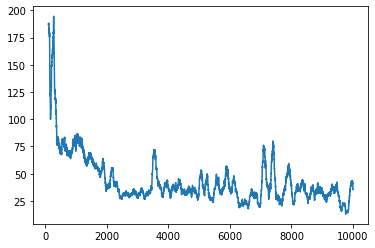

In [9]:
pd.Series(episode_durations).rolling(100).mean().plot()

In [10]:
val_2=0
val_1=0

el = env.maze.shape[0]


man_ag = {}
j = {}
jv = {}
j1v = {}
for level in range(env.n_layers):
    
    ml = env.manager_view**(env.n_layers-level)
    em = int(el / ml)
    
    print(level)
    man_ag[level]={}
    lisv = []
    sm = []
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[level][y * el + j2] = a[level][0] * (el/env.manager_view**(env.n_layers-level)) + a[level][1]
            if a[level] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[level])
    print(lisv)
    print(sm)
    j[level] = []
    jv[level] = []
    j1v[level] = []
    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = level

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, level)
        if level==0:
            t=4
            
        else:
            p = int(man_ag[level-1][s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
            t = action_dict_r[j[level-1][p]]
        
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j[level].append(action_dict[aa[torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[1].item()]])
        j1v[level].append(torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[0].item())
        jv[level].append([(x, Q_policy.forward(state, level, env).flatten()[x].item()) for x in aa])
    if level!=0:
        print(np.array(j[level]).reshape(em, em))
        print(np.array(jv[level]).reshape(em, em))
j2 = []
j2v = []
value_list = {}
for s in range(el ** 2):

    #     if int(s/8)+s%8<16:
    state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
    state[:el ** 2] = torch.tensor(env.maze.flatten())
    #         aa=env.possible_actions(m,[int(s/8),s%8])
#     state[el ** 2:2 * el ** 2] = val_2
    m = env.n_layers
#     this is used to find task
    p = int(man_ag[env.n_layers-1][s])
    # p = int(s / 4) * 2 + int((s / 2) % 4)
    t = action_dict_r[j[env.n_layers-1][p]]
#     print(s,p,t)
#     gm = env.get_super_manager_1([int(s / el), int(s % el)])[env.n_layers-1]
#     for x in range(el ** 2):
#         sm = env.get_super_manager_1([int(x / el), int(x % el)])[env.n_layers-1]
#         if sm == gm:
#             state[el ** 2 + x] = 0

    state[s + el ** 2] = 1
    state[2 * el ** 2 + m] = 1
    state[2 * el ** 2 + env.n_layers+1 + t] = 1
    #         print(p, s, m, t)
    #         print()
    #         print(state)
    if [int(s / el), int(s % el)] == env.goal_init_state:
        j2.append('X')
        j2v.append(0)
    elif env.maze[int(s / el), int(s % el)] == 1:
        vv = Q_policy.forward(state, env.n_layers, env)
        j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    else:
        vv = Q_policy.forward(state, env.n_layers, env)
        value_list[s] = vv.cpu().detach().numpy()
        j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
print(np.array(j2).reshape(el, el
                           ))
print('xxx')

0
[0]
[[0.0, 0.0]]
1
[0, 4, 32, 36]
[[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
[['E' 'S']
 ['E' 'Search']]
[[list([(0, -24.82455825805664), (1, -20.489290237426758), (2, -18.115962982177734), (3, -25.205236434936523)])
  list([(0, -18.112733840942383), (1, -13.203215599060059), (2, -22.75364112854004), (3, -18.239234924316406)])]
 [list([(0, -14.087577819824219), (1, -16.4484806060791), (2, -4.866745471954346), (3, -14.140619277954102)])
  list([(4, 0.6521901488304138)])]]
2
[0, 2, 4, 6, 16, 18, 20, 22, 32, 34, 36, 38, 48, 50, 52, 54]
[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [1.0, 3.0], [2.0, 0.0], [2.0, 1.0], [2.0, 2.0], [2.0, 3.0], [3.0, 0.0], [3.0, 1.0], [3.0, 2.0], [3.0, 3.0]]
[['E' 'E' 'S' 'S']
 ['E' 'E' 'E' 'N']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -2.762131452560425), (1, -2.541703701019287), (2, -0.905993640422821), (3, -3.1306209564208984)])
  list([(0, -2.730957508087158), (1, -1.9837051630020142), (2, -0.94

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'E' 'E' 'S' 'S' 'S' 'S']
 ['E' 'E' 'E' 'E' 'S' 'S' 'S' 'S']
 ['E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'S' 'N']
 ['E' 'E' 'E' 'S' 'X' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'W' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'W' 'W']]
xxx


In [38]:
val_2=0
val_1=0

el = env.maze.shape[0]


man_ag = {}
j = {}
jv = {}
j1v = {}
for level in range(env.n_layers):
    
    ml = env.manager_view**(env.n_layers-level)
    em = int(el / ml)
    
    print(level)
    man_ag[level]={}
    lisv = []
    sm = []
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[level][y * el + j2] = a[level][0] * (el/env.manager_view**(env.n_layers-level)) + a[level][1]
            if a[level] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[level])
    print(lisv)
    print(sm)
    j[level] = []
    jv[level] = []
    j1v[level] = []
    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = level

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, level)
        if level==0:
            t=4
            
        else:
            p = int(man_ag[level-1][s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
            t = action_dict_r[j[level-1][p]]
        
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j[level].append(action_dict[aa[torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[1].item()]])
        j1v[level].append(torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[0].item())
        jv[level].append([(x, Q_policy.forward(state, level, env).flatten()[x].item()) for x in aa])
    if level!=0:
        print(np.array(j[level]).reshape(em, em))
        print(np.array(jv[level]).reshape(em, em))
j2 = []
j2v = []
value_list = {}
for s in range(el ** 2):

    #     if int(s/8)+s%8<16:
    state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
    state[:el ** 2] = torch.tensor(env.maze.flatten())
    #         aa=env.possible_actions(m,[int(s/8),s%8])
#     state[el ** 2:2 * el ** 2] = val_2
    m = env.n_layers
#     this is used to find task
    p = int(man_ag[env.n_layers-1][s])
    # p = int(s / 4) * 2 + int((s / 2) % 4)
    t = action_dict_r[j[env.n_layers-1][p]]
#     print(s,p,t)
#     gm = env.get_super_manager_1([int(s / el), int(s % el)])[env.n_layers-1]
#     for x in range(el ** 2):
#         sm = env.get_super_manager_1([int(x / el), int(x % el)])[env.n_layers-1]
#         if sm == gm:
#             state[el ** 2 + x] = 0

    state[s + el ** 2] = 1
    state[2 * el ** 2 + m] = 1
    state[2 * el ** 2 + env.n_layers+1 + t] = 1
    #         print(p, s, m, t)
    #         print()
    #         print(state)
    if [int(s / el), int(s % el)] == env.goal_init_state:
        j2.append('X')
        j2v.append(0)
    elif env.maze[int(s / el), int(s % el)] == 1:
        vv = Q_policy.forward(state, env.n_layers, env)
        j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    else:
        vv = Q_policy.forward(state, env.n_layers, env)
        value_list[s] = vv.cpu().detach().numpy()
        j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
print(np.array(j2).reshape(el, el
                           ))
print('xxx')

0
[0]
[[0.0, 0.0]]
1
[0, 4, 32, 36]
[[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
[['E' 'W']
 ['E' 'Search']]
[[list([(0, -1.8144561052322388), (1, -2.080950975418091), (2, -1.1795568466186523), (3, -1.6329766511917114)])
  list([(0, -1.8655589818954468), (1, -2.3412840366363525), (2, -2.282491683959961), (3, -1.241301417350769)])]
 [list([(0, -1.617193579673767), (1, -2.0131771564483643), (2, -1.2099958658218384), (3, -1.602731704711914)])
  list([(4, -0.18294140696525574)])]]
2
[0, 2, 4, 6, 16, 18, 20, 22, 32, 34, 36, 38, 48, 50, 52, 54]
[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [1.0, 3.0], [2.0, 0.0], [2.0, 1.0], [2.0, 2.0], [2.0, 3.0], [3.0, 0.0], [3.0, 1.0], [3.0, 2.0], [3.0, 3.0]]
[['E' 'W' 'S' 'W']
 ['E' 'W' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['S' 'E' 'N' 'N']]
[[list([(0, -17.13278579711914), (1, -15.96810531616211), (2, -15.826748847961426), (3, -17.861326217651367)])
  list([(0, -17.794647216796875), (1, -17.08136558532715), (2, -1

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['W' 'E' 'E' 'E' 'W' 'W' 'W' 'W']
 ['N' 'E' 'E' 'E' 'W' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'W' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'W' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'X' 'W' 'W' 'W']
 ['N' 'N' 'E' 'N' 'N' 'N' 'W' 'W']
 ['S' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['S' 'N' 'E' 'E' 'N' 'N' 'N' 'N']]
xxx


In [12]:
lisv

[0, 2, 4, 6, 16, 18, 20, 22, 32, 34, 36, 38, 48, 50, 52, 54]

In [20]:
def print_policy(Q_policy, env, val_1, val_2):
    val_2=0
    val_1=0
    j = []
    jv = []
    j1v = []
    el = env.maze.shape[0]
    ml = env.manager_view
    em = int(el / ml)
    lisv = []
    sm = []
    man_ag = {}
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[y * el + j2] = a[1][0] * (el/env.manager_view*(env.n_layers-1)) + a[1][1]
            if a[-1] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[-1])

    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(em, em))
    print(np.array(jv).reshape(em, em))

    j2 = []
    j2v = []
    value_list = {}
    for s in range(el ** 2):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[el ** 2:2 * el ** 2] = val_2
        m = 2
    #     this is used to find task
        p = int(man_ag[s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / el), int(s % el)])[1]
        for x in range(el ** 2):
            sm = env.get_super_manager_1([int(x / el), int(x % el)])[1]
            if sm == gm:
                state[el ** 2 + x] = 0

        state[s + el ** 2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + 3 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / el), int(s % el)] == env.goal_init_state:
            j2.append('X')
            j2v.append(0)
        elif env.maze[int(s / el), int(s % el)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(el, el
                               ))
    print('xxx')

    V = np.array(j1v)
    num_man = int(el / ml)
    cells = [[x, y] for x in range(num_man) for y in range(num_man)]
    policy = np.array(j).reshape(num_man, num_man)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, num_man)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
    V = np.array(j2v)
    cells = [[x, y] for x in range(el) for y in range(el)]
    policy = np.array(j2).reshape(el, el)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, el)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')

In [18]:
man_ag

{0: 0.0,
 1: 0.0,
 2: 1.0,
 3: 1.0,
 4: 2.0,
 5: 2.0,
 6: 3.0,
 7: 3.0,
 8: 0.0,
 9: 0.0,
 10: 1.0,
 11: 1.0,
 12: 2.0,
 13: 2.0,
 14: 3.0,
 15: 3.0,
 16: 4.0,
 17: 4.0,
 18: 5.0,
 19: 5.0,
 20: 6.0,
 21: 6.0,
 22: 7.0,
 23: 7.0,
 24: 4.0,
 25: 4.0,
 26: 5.0,
 27: 5.0,
 28: 6.0,
 29: 6.0,
 30: 7.0,
 31: 7.0,
 32: 8.0,
 33: 8.0,
 34: 9.0,
 35: 9.0,
 36: 10.0,
 37: 10.0,
 38: 11.0,
 39: 11.0,
 40: 8.0,
 41: 8.0,
 42: 9.0,
 43: 9.0,
 44: 10.0,
 45: 10.0,
 46: 11.0,
 47: 11.0,
 48: 12.0,
 49: 12.0,
 50: 13.0,
 51: 13.0,
 52: 14.0,
 53: 14.0,
 54: 15.0,
 55: 15.0,
 56: 12.0,
 57: 12.0,
 58: 13.0,
 59: 13.0,
 60: 14.0,
 61: 14.0,
 62: 15.0,
 63: 15.0}

In [14]:
j

['E',
 'E',
 'S',
 'S',
 'E',
 'E',
 'S',
 'S',
 'E',
 'E',
 'Search',
 'W',
 'E',
 'E',
 'N',
 'W']

[['E' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'N']]
[[list([(0, -22.795738220214844), (1, -19.7792911529541), (2, -17.21353530883789), (3, -22.668209075927734)])
  list([(0, -23.328182220458984), (1, -13.496849060058594), (2, -14.514488220214844), (3, -18.742496490478516)])
  list([(0, -18.86495590209961), (1, -9.267934799194336), (2, -15.143957138061523), (3, -16.181568145751953)])
  list([(0, -22.027339935302734), (1, -14.772747039794922), (2, -19.442447662353516), (3, -12.18844223022461)])]
 [list([(0, -19.810590744018555), (1, -21.56981086730957), (2, -13.436161994934082), (3, -28.40165138244629)])
  list([(0, -15.919818878173828), (1, -15.787995338439941), (2, -8.206682205200195), (3, -18.348430633544922)])
  list([(0, -9.913793563842773), (1, -3.114133834838867), (2, -8.457708358764648), (3, -11.820131301879883)])
  list([(0, -14.185837745666504), (1, -12.835290908813477), (2, -14.509785652160645), (3, -7.5399580001831055)])]
 [list([(0, -21.87051200

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'E' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W' 'W' 'W']
 ['ME' 'E' 'ME' 'S' 'MS' 'S' 'MS' 'S' 'MS' 'S' 'MS' 'S' 'MW' 'W' 'MW' 'W']
 ['ME' 'ME' 'E' 'S' 'MS' 'MS' 'S' 'S' 'MS' 'MS' 'S' 'S' 'MS' 'MS' 'W' 'W']
 ['E' 'ME' 'ME' 'E' 'S' 'MS' 'MS' 'S' 'S' 'MS' 'MS' 'S' 'W' 'MW' 'MW' 'W']
 ['ME' 'ME' 'ME' 'ME' 'E' 'E' 'E' 'S' 'MS' 'MS' 'MS' 'ME' 'W' 'W' 'W' 'W']
 ['E' 'ME' 'E' 'ME' 'ME' 'E' 'ME' 'E' 'S' 'MS' 'S' 'MS' 'MW' 'W' 'MW' 'W']
 ['E' 'E' 'ME' 'ME' 'ME' 'ME' 'E' 'E' 'S' 'S' 'MS' 'MS' 'MW' 'MW' 'W' 'W']
 ['ME' 'E' 'E' 'ME' 'E' 'ME' 'ME' 'E' 'MS' 'S' 'S' 'MS' 'W' 'MW' 'MW' 'W']
 ['ME' 'ME' 'ME' 'ME' 'ME' 'ME' 'ME' 'ME' 'X' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['E' 'ME' 'E' 'ME' 'S' 'ME' 'E' 'ME' 'MN' 'N' 'MN' 'N' 'MW' 'W' 'MW' 'W']
 ['E' 'E' 'ME' 'ME' 'E' 'S' 'ME' 'ME' 'MN' 'MN' 'N' 'N' 'MW' 'MW' 'W' 'W']
 ['ME' 'E' 'E' 'ME' 'ME' 'E' 'E' 'ME' 'N' 'MN' 'MN' 'N' 'W' 'MW' 'MW' 'W']
 ['E' 'E' 'E' 'S' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'N' 'W' 'W' 'N']
 ['ME' 'E' 'ME' 'E' 'N' 'MN' 'N' 

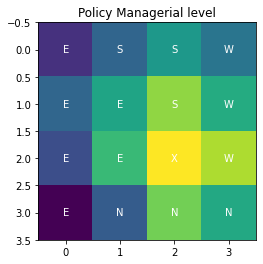

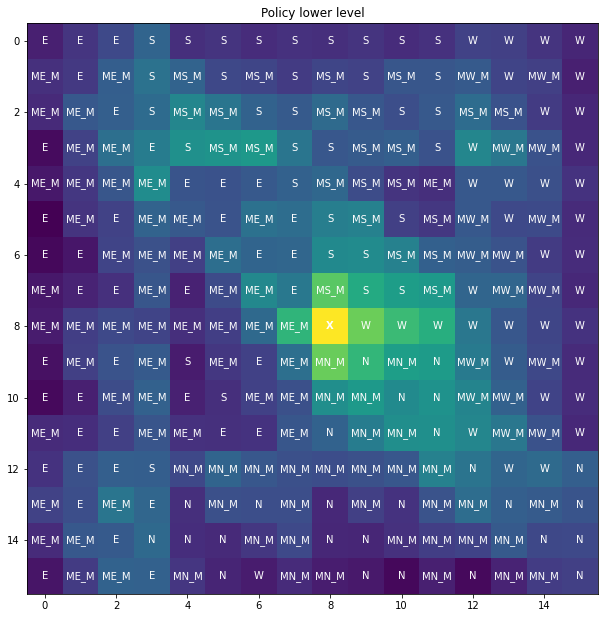

cccc


In [21]:
print_policy(Q_policy, env, 0, 0)

In [67]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}


class FlatHierarchicalQ():
    def __init__(self, env):
        self.counter = 0
        self.Q_table = {}
        self.epsilon = 0.1
        self.layer_states = {}
        for level in range(int(env.n_layers + 1)):
            ns = (env.maze.shape[0] / (env.manager_view ** (env.n_layers - level))) ** 2
            self.Q_table[level] = {}
            self.layer_states[level] = ns ** 0.5
            for state in range(int(ns)):
                self.Q_table[level][state] = {}
                for task in range(env.na + 1):
                    self.Q_table[level][state][task] = {}
                    for action in range(env.na + 1):
                        self.Q_table[level][state][task][action] = 0

    def update_Q_values(self, env, ns, state, level, reward, action, task, done, episode, num_episodes, discount_factor,
                        allowed_future_actions):

        alpha_0 = 0.5
        tau = 50
        #         if episode<num_episodes-500:
        #             episode_1=episode%100
        #         else:
        #             episode_1=episode
        div = num_episodes / 50
        alpha = 1 - (alpha_0 * tau) / (tau + (episode / div))
        self.alpha_new = 1 - alpha

        state1 = state[0] * self.layer_states[level] + state[1]
        n_state1 = ns[0] * self.layer_states[level] + ns[1]
        #         allowed_future_actions=env.possible_actions(level,ns)
        if done:
            maxq = 0
        elif len(allowed_future_actions) != 1:
            maxq = np.max([self.Q_table[level][n_state1][task][a] for a in allowed_future_actions])
        else:
            assert 4 in allowed_future_actions
            maxq = np.max(self.Q_table[level][n_state1][task][4])
        current_q_value = self.Q_table[level][state1][task][action] + self.alpha_new * (
                    reward + discount_factor * maxq - self.Q_table[level][state1][task][action])
        self.Q_table[level][state1][task][action] = current_q_value

    def choose_action(self, env, level, state1, task, episode, num_eps):
        #         which level
        allowed_actions = env.possible_actions(level, state1)

        #         allowed_actions = self.actions_possible[level]

        #         if level == 2:
        #             eps = np.maximum(.1, .5 - .5 * (episode * 2 / num_eps))
        #         else:
        #             eps = np.maximum(.1, .5 - .5 * (episode * 4 / num_eps))
#         print('level',level)
#         print('allowed_actions',allowed_actions)
        eps = 0.1
        if level == 0:
            return 4

        elif level != env.n_layers:
            #             task = env.hierarchy_actions[level - 1]
            state = env.get_super_manager_1(state1)[level]
        else:
            state = state1
            self.counter = self.counter + 1
        #             task = env.hierarchy_actions[level - 1]
        #             state = env.loc
        # print(level, state, task)
        #         if level!=env.n_layers:
        #             goal=env.get_super_manager_1(env.goal_init_state)[level]
        #             goal = goal[0] * self.layer_states[level] + goal[1]

        #         else:
        #             goal=0

        state_1 = state[0] * self.layer_states[level] + state[1]
        action_values = [self.Q_table[level][state_1][task][y] for y in allowed_actions]
        # print(action_values)
        # action_values = np.argmax(a)
        # boltz = [np.exp((x)) for x in action_values]
        # boltz = boltz / (np.sum(boltz) + 1e-8)
        # print(level,allowed_actions)
        # if level==env.n_layers:
        self.epsilon = eps

        if allowed_actions[0] == 4:
            return 4, eps
        else:
            if random.random() < self.epsilon:
                preferred_action = [random.choice(allowed_actions)]
            else:
                preferred_action = [random.choice(np.where(action_values == np.max(action_values))[0])]
            actual_action = preferred_action[0]
            #         print(actual_action)
            #         print(self.epsilon)
            return actual_action, eps











  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[7, 2]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[1, 1] 1
[ 0  1  2  3  8  9 10 11 16 17 18 19 24 25 26 27]
[1, 1] 2
[0 1 8 9]
9
17
16
16
17
[1, 1] 2
[18 19 26 27]


ValueError: only one element tensors can be converted to Python scalars

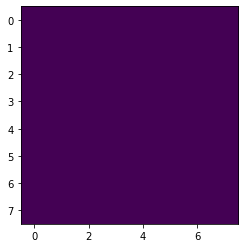

In [68]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}

import matplotlib.pyplot as plt

env = Hierarchical_Maze(8, 3, 2, 2, False, False, 2, False, 0)
# env=Normal_Maze(22)
FlatQ = FlatHierarchicalQ(env)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
ell=int(env.maze.shape[0]/2)
env.goal_init_state = [ell,ell]


# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 5000
batch_size = 1
discount_factor = 1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}

device = torch.device("cpu")

for length in [7]:
#     for num_hidden in  [int(n_input*1.1)]:
# counter=0
    n_input = 2*length ** 2 + 8

    for num_hidden in  [int(2*length ** 2)]:
#                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
#     for length in [3]:
        memory = ReplayMemory(1)



        Q_policy = QNetwork(env, n_input, num_hidden, device,length).to(device)
        Q_target = QNetwork(env, n_input, num_hidden, device,length).to(device)

        # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
        # Q_target = QNetwork(n_input, num_hidden, device).to(device)

        # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
        # target_net = DQN(screen_height, screen_width, n_actions).to(device)
        Q_target.load_state_dict(Q_policy.state_dict())
        Q_target.eval()
        allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

        policy = EpsilonGreedyPolicy(Q_policy, 0.08)

        episode_durations, losses, Visit_table,rewards,cl = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                              batch_size,
                                                              discount_factor, learn_rate, np.minimum(500,num_episodes))
        r_dict_3[counter]={'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                         'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
        counter=counter+1
#         import matplotlib.pyplot as plt
#         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')


In [4]:
pd.Series(rewards).rolling(50).mean().max()

-115.8

In [5]:
pd.Series(rewards).rolling(100).mean()

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
2995   -1051.74
2996   -1051.53
2997   -1052.19
2998   -1052.16
2999   -1049.13
Length: 3000, dtype: float64

<AxesSubplot:>

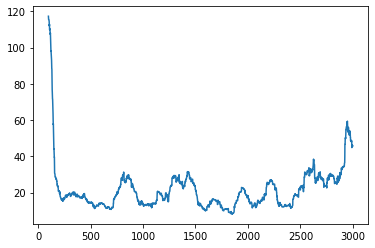

In [6]:
pd.Series(episode_durations).rolling(100).mean().plot()

<AxesSubplot:>

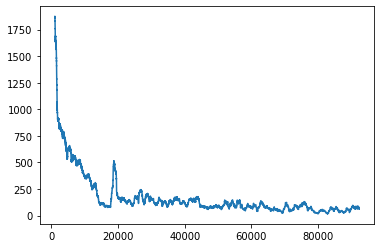

In [6]:
pd.Series(losses).rolling(1000).mean().plot()

In [46]:
j = []
jv = []
j1v = []
el = env.maze.shape[0]
ml = env.manager_view
em = int(el / ml)
lisv = []
sm = []
man_ag = {}
for l in range(env.n_layers):
    man_ag[l]={}
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])
            man_ag[l][y * el + j2] = a[l][0] * 2 + a[l][1]
            if a[-1] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[-1])



In [48]:
Q_policy.get_subs([int(x / env.manager_view**l) for x in current_loc],
                                                                       env, current_level)

[0, 2, 4, 6, 16, 18, 20, 22, 32, 34, 36, 38, 48, 50, 52, 54]

In [ ]:
for i, s in enumerate(lisv):
    #     if int(s/8)+s%8<16:

    state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
    state[:el ** 2] = torch.tensor(env.maze.flatten())
    m = 1

    aa = env.possible_actions(m, [int(s / el), s % el])
    loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

    t = 4
    state[el ** 2:2 * el ** 2] = 0
    state[el ** 2 + loc_idx2] = 1
    state[2 * el ** 2 + m] = 1
    state[2 * el ** 2 + env.n_layers+1 + t] = 1
    #         print(state)

    j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
    j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
    jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
print(np.array(j).reshape(em, em))
print(np.array(jv).reshape(em, em))

In [62]:
policy={}
el=env.maze.shape[0]
for level in FlatQ.Q_table.keys():
    if level !=0:
        
        for ag in FlatQ.Q_table[level].keys():
#             for each agent in each level, find corresponding lowest level state
#  e,g, fir 0,0 always 0,0
# corresponding lowest state will be agent times manager view that layer
#  so at lowest layer it will be 1 as there's no managing
#  next layer it will be 2 so [0...15] becomes [ 7....7]
#  in flat q table every agent divided by 2
# until dividing by 2<1
#  so can be oppositie here
# multiply by 2 ^ level 
#  so maze 16*16 man layer 4
#  man layer 0 view is irrelevant
#  man layer 1 view there are 4 managers --> view is 8 --> 2**3 which is 2**(layers -level )
# so 0,0 becomes 0,0
#  1 ,1 becomes 8,8
#  01 0 8
# 1,0 8 ,0
            ag=int(ag/(env.manager_view**(level)))
    
#             ag2=np.maximum(ag%(env.manager_view**(level))-1,0)
            
            state=[ag*(env.manager_view**(env.n_layers-level+1)),ag*(env.manager_view**(env.n_layers-level+1))
                  ]
            step=env.manager_view**level
            man=env.get_super_manager_1(state)[level-1]
            man_idx=man[0]*step+man[1]%step
            print(ag,state,man,man_idx,level-1)
#             options=FlatQ.Q_table[level][ag][]
    else:
        
        policy[level]={'Action':4,'Value':0}
            


0 [0, 0] [0.0, 0.0] 0.0 0
0 [0, 0] [0.0, 0.0] 0.0 0
1 [16, 16] [1.0, 1.0] 3.0 0
1 [16, 16] [1.0, 1.0] 3.0 0
0 [0, 0] [0.0, 0.0] 0.0 1
0 [0, 0] [0.0, 0.0] 0.0 1
0 [0, 0] [0.0, 0.0] 0.0 1
0 [0, 0] [0.0, 0.0] 0.0 1
1 [8, 8] [1.0, 1.0] 5.0 1
1 [8, 8] [1.0, 1.0] 5.0 1
1 [8, 8] [1.0, 1.0] 5.0 1
1 [8, 8] [1.0, 1.0] 5.0 1
2 [16, 16] [2.0, 2.0] 10.0 1
2 [16, 16] [2.0, 2.0] 10.0 1
2 [16, 16] [2.0, 2.0] 10.0 1
2 [16, 16] [2.0, 2.0] 10.0 1
3 [24, 24] [3.0, 3.0] 15.0 1
3 [24, 24] [3.0, 3.0] 15.0 1
3 [24, 24] [3.0, 3.0] 15.0 1
3 [24, 24] [3.0, 3.0] 15.0 1
0 [0, 0] [0.0, 0.0] 0.0 2
0 [0, 0] [0.0, 0.0] 0.0 2
0 [0, 0] [0.0, 0.0] 0.0 2
0 [0, 0] [0.0, 0.0] 0.0 2
0 [0, 0] [0.0, 0.0] 0.0 2
0 [0, 0] [0.0, 0.0] 0.0 2
0 [0, 0] [0.0, 0.0] 0.0 2
0 [0, 0] [0.0, 0.0] 0.0 2
1 [4, 4] [1.0, 1.0] 9.0 2
1 [4, 4] [1.0, 1.0] 9.0 2
1 [4, 4] [1.0, 1.0] 9.0 2
1 [4, 4] [1.0, 1.0] 9.0 2
1 [4, 4] [1.0, 1.0] 9.0 2
1 [4, 4] [1.0, 1.0] 9.0 2
1 [4, 4] [1.0, 1.0] 9.0 2
1 [4, 4] [1.0, 1.0] 9.0 2
2 [8, 8] [2.0, 2.0] 18.0 2
2 [8, 8] 

In [55]:
env.get_super_manager_1([0,15])

[[0.0, 0.0], [0.0, 1.0], [0.0, 3.0], [0.0, 7.0]]

In [28]:
env.n_layers-2

2

In [20]:
for x in FlatQ.Q_table.keys():
    print(FlatQ.Q_table[x].keys())

dict_keys([0])
dict_keys([0, 1, 2, 3])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 1

In [13]:
loc=[255,255]
super_managers = []
number_of_levels = int(4)
#         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
# print(loc)

super_managers[::-1]

[]

In [81]:
counter

3

255

In [36]:
env.get_super_manager_1([15,15])

[[0.0, 0.0], [1.0, 1.0], [3.0, 3.0], [7.0, 7.0]]

In [14]:
env.get_super_manager_1([7,7])

[[0.0, 0.0], [0.0, 0.0], [1.0, 1.0], [3.0, 3.0]]

In [30]:
FlatQ.Q_table[1]

{0: {0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  2: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  3: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  4: {0: -88.02245555258138,
   1: -71.8524212901463,
   2: -103.93404192770888,
   3: -73.18619228893118,
   4: 0}},
 1: {0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  2: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  3: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  4: {0: -98.19270833333333,
   1: -85.34156866559748,
   2: -82.69402249967402,
   3: -104.78125,
   4: 0}},
 2: {0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  2: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  3: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  4: {0: -81.39415982597343,
   1: -128.11729117381677,
   2: -83.70783729121594,
   3: -110.39736289504981,
   4: 0}},
 3: {0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  2: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  3: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
  4: {0: 0, 1: 0, 2: 0, 3: 0, 4: -102.8880198078

In [ ]:
for each level:
    find optimal task given by manager for managers allowed actions
        find optimal action for allowed actions